<a href="https://colab.research.google.com/github/descobargarcia/ingenieria-quimica/blob/colab_import/03_Regresi%C3%B3n_Presi%C3%B3n_Vapor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AJUSTE DE DATOS DE PRESIÓN DE VAPOR DEL METANOL MEDIANTE MODELOS DE REGRESIÓN

La presión de saturación de vapor ($P^{sat}$) es una propiedad fisicoquímica de los fluidos, que indica su facilidad para evaporarse a una temperatura especificada ($T$). Si la presión ejercida sobre el fluido es menor que su presión de vapor ($P<P^{sat}$), entonces estará en fase vapor. En cambio, si la presión ejercida es superior a la presión de vapor ($P>P^{sat}$), el fluido estará en fase líquida.

En la Ingeniería de Procesos Químicos, existen muchos escenarios donde es necesario evaluar esta propiedad. Como ejemplos, se pueden mencionar: los ciclos de refrigeración, las columnas de destilación y absorción, las torres de enfriamiento, el secado de alimentos, el diseño de tanques de almacenamiento y prevenir la cavitación en bombas, entre muchos otros. Por tanto, resulta de interés tener modelos confiables para correlacionar y predecir la presión de vapor de los fluidos de trabajo, en función de la temperatura.

En este artículo, vamos a analizar y procesar datos experimentales de la presión de vapor del fluido metanol para ajustar 2 modelos de regresión. El primer modelo (Clausius-Clapeyron) es linealizable, mientras que el segundo (Antoine) no. En el proceso, aplicaremos conceptos clave como estadística descriptiva, distribución, transformaciones de variables, estratificación, conjuntos *train-set* y *test-set*, métricas de error, entre otros.

Como herramientas de trabajo, aplicaremos diferentes librerías de Python. Aplicaremos muchas funcionalidades de `pandas` para el procesamiento y análisis de datos, alternando con `Matplolib` para la visualización. Usaremos `pint` para resolver las conversiones de unidades. `NumPy` nos permitirá trabajar con funciones vectoriales y arreglos; además, es el núcleo de las librerías de Ciencia de Datos. Finalmente, usaremos `SciKit Learn` y `SciPy` para el entrenamiento y evaluación de los modelos de regresión.



## DataFrame inicial

Para cargar los datos experimentales, utilizamos la librería `pandas` y la función `read_csv()`:

In [1]:
import pandas as pd

url_repositorio = "https://github.com/descobargarcia/datos_exp/raw/main/"
archivo_datos = "datos_presion_vapor_metanol.csv"
url_archivo_datos = url_repositorio + archivo_datos
df_inic = pd.read_csv(url_archivo_datos)
display(df_inic)

,T_magnitud,T_unidad,P_magnitud,P_unidad,Fuente
0,13.88,degC,0.09200,atm,Dever et al. (1955)
1,14.60,degC,0.09580,atm,Dever et al. (1955)
2,15.37,degC,0.09975,atm,Dever et al. (1955)
3,15.70,degC,0.10170,atm,Dever et al. (1955)
4,16.34,degC,0.10560,atm,Dever et al. (1955)
...,...,...,...,...,...
162,196.10,degC,36.40000,atm,Hirata; Suda (1967)
163,199.50,degC,38.84000,atm,Hirata; Suda (1967)
164,200.60,degC,39.79000,atm,Hirata; Suda (1967)
165,200.70,degC,39.79000,atm,Hirata; Suda (1967)


Como puede observar, los datos están representados como una tabla de 167 filas y 5 columnas. Las columnas corresponden a los atributos. En este caso, tenemos 2 atributos numéricos (T_magnitud, P_magnitud) y 3 atributos no numéricos (T_unidad, P_unidad, Fuente). Si queremos más información sobre los valores y frecuencia de estos últimos atributos, podemos utilizar el método `value_counts()`:

In [2]:
display(df_inic["Fuente"].value_counts())
print("")
display(df_inic["T_unidad"].value_counts())
print("")
display(df_inic["P_unidad"].value_counts())

Fuente
Gibbard et al. (1974)     42
Dever et al. (1955)       39
Ambrose et al. (1975)     24
Safarov (2019)            22
Ambrose; Sprake (1970)    20
Hirata; Suda (1967)       20
Name: count, dtype: int64

T_unidad
degK    108
degC     59
Name: count, dtype: int64

P_unidad
kPa    86
atm    59
Pa     22
Name: count, dtype: int64

Tenemos 6 categorías de "Fuente", 2 categorías de unidades de temperatura `{degK, degC}` y 3 categorías de unidades de presión `{kPa, atm, Pa}`. Tener la data en diferentes unidades es un problema, porque los valores numéricos no se pueden analizar todavía. Por ejemplo, así como no puede sumar peras y manzanas, no tiene sentido promediar valores de presión en `{atm}` con valores en `{Pa}`. Por tanto, debemos elegir primero una unidad apropiada para cada variable numérica y convertir todos los valores de dicha variable a la unidad elegida.

¿Cuál sería la forma más eficiente de hacerlo? Podríamos implementar ahora nuestras propias funciones de conversión de unidades (como hicimos en otras publicaciones), pero no garantiza el mantenimiento ni escalabilidad del proyecto. Por ejemplo, imagine que consigue nuevos datos experimentales de otras fuentes y desea incluirlos, pero reportan *T* en **{ºF, ºR}** y *P* en **{bar, mmHg, psi}**. Sería muy tedioso implementar nuevas conversiones de unidades en cada actualización del conjunto de datos.

Afortunadamente, la librería `pint` nos permite automatizar el manejo de unidades, de una forma rápida y simple. Para utilizarla, primero debemos instalarla y luego importarla:

## Librería `pint`

In [3]:
!pip install pint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 5.5 MB/s eta 0:00:00


In [4]:
# pylint: disable = reportGeneralTypeIssues

from pint import UnitRegistry

ureg = UnitRegistry()   # Registro de unidades
Q_ = ureg.Quantity      # Constructor de cantidades físicas ('Quantities')

Para definir una cantidad física, creamos un objeto de tipo `Quantity` a partir de la *magnitud* (valor numérico) y la *unidad* (string). Estos atributos pueden consultarse luego como `magnitude` y `units`, como se muestra a continuación:

In [5]:
# Definiendo entalpía (kJ/kg)
h1 = Q_(100, 'kJ/kg')   # ignorar resaltado rojo en Colab
# Conversión -> (J/kg)
h2 = h1.to('J/kg')

# Imprimiendo resultados
print(f"h1 = {h1}")
print(f"h2 = {h2}")
print(f"{h2.magnitude = }")
print(f"{h2.units = }")

h1 = 100 kilojoule / kilogram
h2 = 100000.0 joule / kilogram
h2.magnitude = 100000.0
h2.units = <Unit('joule / kilogram')>


Otra característica interesante es que podemos comparar cantidades físicas. Por ejemplo, si repasamos la conversión de temperatura de Celsius a Kelvin: $T_{(K)} = T_{(ºC)} + 273.15$, sabemos que una temperatura de 20 ºC equivale a 293.15 K. La librería `pint` identifica correctamente esta situación:

In [6]:
# Definiendo temperaturas
T1 = Q_(20, 'degC')
T2 = Q_(293.15, 'K')
T3 = Q_(300, 'degK')

# Imprimiendo resultados
print(f"T1 = {T1}")
print(f"T2 = {T2}")
print(f"T3 = {T3}")
# Comparación de temperaturas
print(f"¿T1 igual a T2? --> {T1 == T2}")
print(f"¿T1 igual a T3? --> {T1 == T3}")

T1 = 20 degree_Celsius
T2 = 293.15 kelvin
T3 = 300 kelvin
¿T1 igual a T2? --> True
¿T1 igual a T3? --> False


Si quiere aprender más sobre la librería `pint`, puede consultar el siguiente [ejemplo](https://kyleniemeyer.github.io/computational-thermo/content/intro-solving-problems.html#convenience-function-to-get-values-in-si-units).

## Vectorización de funciones

A partir de los métodos de la librería `pint`, creamos funciones vectorizadas para convertir valores de presión a `{kPa}` y valores de temperatura a `{K}`. Las funciones vectorizadas pueden aplicarse sobre *series* de `pandas`, ya que están basadas en *arreglos* de `NumPy`.

Es importante que estas funciones retornen solamente el valor numérico (en lugar de objetos `Quantity`), a fin de que los resultados puedan procesarse luego en forma correcta por las librerías de Ciencia de Datos. A continuación, importamos la librería `NumPy` y definimos las funciones requeridas:

In [7]:
import numpy as np

def convertir_T_kelvin(magnitud: float, unidad: str) -> float:
    T = Q_(magnitud, unidad)
    return T.to('K').magnitude

def convertir_P_kPa(magnitud: float, unidad: str) -> float:
    P = Q_(magnitud, unidad)
    return P.to('kPa').magnitude

calc_T_data_kelvin = np.vectorize(convertir_T_kelvin)
calc_P_data_kPa = np.vectorize(convertir_P_kPa)

## Nuevo DataFrame: unidades consistentes

Como ahora obtendremos todas las *T* en `{K}`, ya no tiene sentido tener 2 atributos separados para *T_magnitud* y *T_unidad*, así que podemos combinarlos en un nuevo atributo numérico `T (K)`. Un razonamiento similar aplica para *P*. A continuación, aplicamos las conversiones de unidades y creamos un nuevo 'DataFrame' en unidades consistentes:

In [8]:
data_unidades_consistentes = {
    "Fuente": df_inic["Fuente"],
    "T (K)": calc_T_data_kelvin(df_inic["T_magnitud"], df_inic["T_unidad"]),
    "P (kPa)": calc_P_data_kPa(df_inic["P_magnitud"], df_inic["P_unidad"]),
}
# Creamos nuevo dataframe
df_trabajo = pd.DataFrame(data_unidades_consistentes)
# Ordenando por valores de T crecientes
df_trabajo.sort_values(by="T (K)", inplace=True)
display(df_trabajo.round(3))

,Fuente,T (K),P (kPa)
39,Safarov (2019),274.15,4.301
40,Safarov (2019),278.15,5.508
41,Safarov (2019),283.15,7.419
0,Dever et al. (1955),287.03,9.322
1,Dever et al. (1955),287.75,9.707
...,...,...,...
166,Hirata; Suda (1967),473.85,4031.722
143,Ambrose et al. (1975),483.20,4844.900
144,Ambrose et al. (1975),493.20,5797.100
145,Ambrose et al. (1975),503.20,6897.400


Como ya tenemos unidades homogéneas para *T* y *P*, ahora sí podemos utilizar los nuevos valores numéricos. Como puede observar, el rango de temperaturas es 274.15 - 512.64 K y el rango de presiones es 4.0301 - 8097.1 kPa. Si queremos métricas adicionales sobre el conjunto de datos, podemos utilizar el método `describe()` de estadística descriptiva:

In [9]:
display(df_trabajo.describe())

,T (K),P (kPa)
count,167.000000,167.000000
mean,349.023711,744.269376
std,63.432552,1415.272455
min,274.150000,4.301000
25%,298.485000,17.230316
50%,323.142000,55.590000
75%,393.005000,638.118500
max,512.640000,8097.100000


Para cada atributo (columna), tenemos las siguientes métricas:

- count: número total de valores registrados
- mean: promedio aritmético
- std: desviación estándar
- min: valor mínimo
- 25%: 1er Quartil --> ejemplo: el 25 % de las *T* son menores a 298.485 K
- 50%: 2do Quartil --> ejemplo: el 50 % de las *P* son menores a 55.59 kPa
- 75%: 3er Quartil
- max: valor máximo



## Diagrama PT: datos experimentales

Podemos graficar los datos experimentales, agrupados según su fuente, mediante la librería `Matplotlib`:

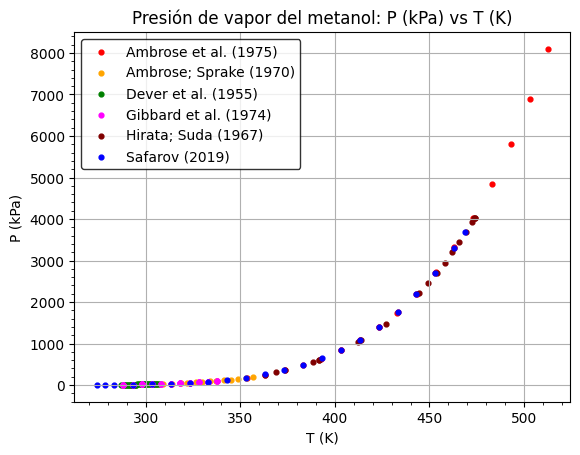

In [10]:
import matplotlib.pyplot as plt

grupos = df_trabajo.groupby("Fuente")
colores = ["red", "orange", "green", "magenta", "maroon", "blue"]

def graficar_datos_presion_vapor(T_label: str, P_label: str) -> None:
    plt.title(f"Presión de vapor del metanol: {P_label} vs {T_label}")
    for ((fuente, datos), color) in zip(grupos, colores):
        x, y = datos[T_label], datos[P_label]
        plt.scatter(x, y, s=12, c=color, label=fuente)
    plt.xlabel(T_label)
    plt.ylabel(P_label)
    plt.minorticks_on()
    plt.grid(True)

graficar_datos_presion_vapor("T (K)", "P (kPa)")
plt.legend(edgecolor="black")
plt.show()

## Linealización de datos: Clausius - Clapeyron

La ecuación de Clausius - Clapeyron se utiliza para modelar la presión de vapor de sustancias puras, en rangos limitados de temperatura:

$$ \log(P^{sat}) = A - \frac{B}{T} $$

El modelo no es lineal, pero con un cambio de variables puede linealizarse. Considere la ecuación general de una recta, donde $a$ representa el intercepto y $b$ la pendiente:

$$ y = a + bx $$

Si definimos $x = 1/T$ e $y = log(P^{sat})$, nos queda una ecuación con una forma similar:

$$ y = A - Bx $$

Podemos obtener los parámetros de Clausius - Clapeyron, a partir de la ecuación de la recta ajustada:

$$
A = a \\
B = -b
$$

Ahora que conocemos el modelo y los cambios de variable requeridos, calculamos las nuevas variables y las agregamos al DataFrame de trabajo:


In [11]:
df_trabajo["1/T (K^-1)"] = 1 / df_trabajo["T (K)"]
df_trabajo["log(P/kPa)"] = np.log10(df_trabajo["P (kPa)"])

Ahora que ya tenemos calculados los nuevos atributos, el lector podría estar tentado en aplicar directamente una regresión lineal, obtener los parámetros del modelo y problema resuelto, ¿verdad? Sin embargo, este procedimiento no es adecuado porque presenta potenciales riesgos, como el **sobreajuste** (*overfitting*). Un modelo sobreajustado correlaciona los datos utilizados, pero no predice apropiadamente nuevos valores.

Para obtener mejores resultados, es preferible aplicar los siguientes pasos:

- Examinar la distribución de los datos en la población total
- Estratificar la población
- Separar los datos en 2 conjuntos estadísticamente representativos de la población: *train-set* y *test-set*
- Ajustar el modelo, correlacionando los datos del *train-set*
- Probar la capacidad predictiva del modelo, utilizando los datos del *test-set*


## Histogramas

Un histograma es un diagrama que representa la frecuencia absoluta (número de repeticiones) de los valores que registra una variable. Es una herramienta muy útil para visualizar la distribución de los datos. Aunque los histogramas están pensados para variables discretas, podemos extender su aplicación a variables continuas si agrupamos en subintervalos los valores de la variable de interés.

A continuación, utilizamos el método `hist()` de la librería `pandas` para obtener los histogramas de cada atributo numérico:

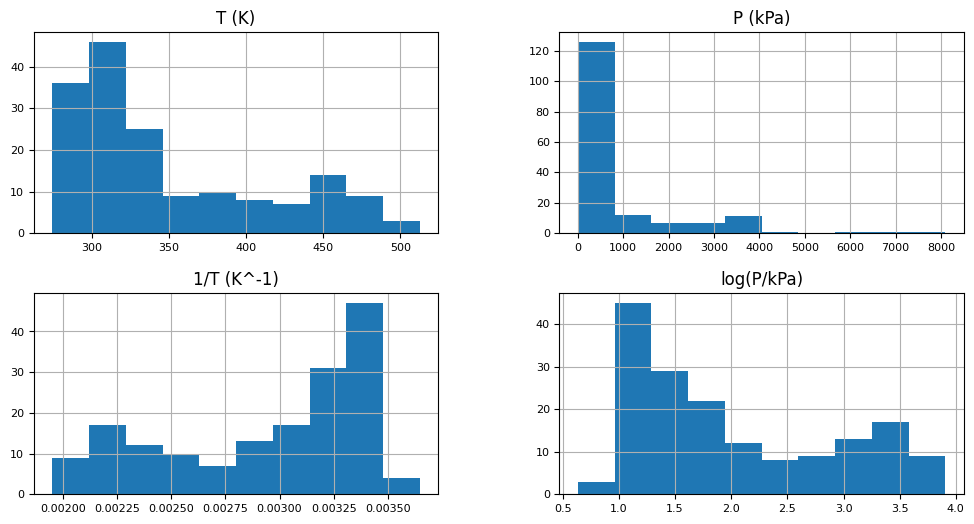

In [12]:
# Tamaño de fuente: valores en los ejes
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

# bins -> número de subintervalos (barras)
df_trabajo.hist(bins=10, figsize=(12, 6))
plt.show()

- La distribución de `log P` es más balanceada que la de `P`.
- Si giramos el histograma de `1/T` hacia la derecha, obtenemos prácticamente el histograma de `log P`. Esta simetría de distribuciones sugiere una buena correlación entre ambas variables.

## Estratificación

La estratificación, también conocida como segmentación de datos, se define como la acción de ordenar datos, personas y objetos en distintos grupos o estratos.

En este ejemplo, vamos a estratificar por intervalos de temperatura. El método `cut` nos permite definir por cuál variable vamos a estratificar, los límites de cada subintervalo y las etiquetas (*labels*) para cada estrato:

In [13]:
df_trabajo["rango_T"] = pd.cut(
    df_trabajo["T (K)"],
    bins=[270.0, 300., 325., 350., 400., 450., np.inf],
    labels=["T1", "T2", "T3", "T4", "T5", "T6"],
)

Advierta que ahora tenemos un atributo "no numérico", así que no será reconocido por el método `hist()`. Sin embargo, podemos graficar el histograma del nuego atributo combinando los métodos `value_counts()` y `plot.bar()`:

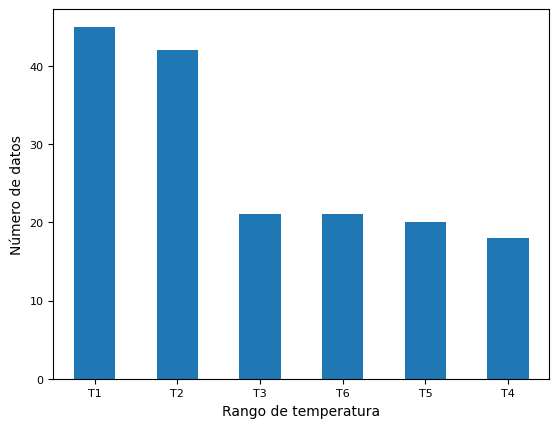

In [14]:
df_trabajo["rango_T"].value_counts().plot.bar(rot=0)
plt.xlabel("Rango de temperatura")
plt.ylabel("Número de datos")
plt.show()

## Train-set y test-set

Ahora que estratificamos la población de datos, podemos dividirla en los conjuntos de entrenamiento (*train-set*) y prueba (*test-set*). Es importante garantizar que "cada conjunto sea estadísticamente representativo de la población". ¿Qué implica esto?

- **La asignación de datos para cada set debe ser aleatoria para evitar sesgos**. Por ejemplo: si el set de entrenamiento contiene solamente datos con T < 400 K, el modelo ajustado probablemente no funcione para T > 400 K.

- **La distribución relativa de los datos debe ser similar entre ambos sets**. Por ejemplo: aunque la probabilidad de lanzar una moneda y obtener cara sea 50 %, no es seguro que en 100 lances ocurran *exactamente* 50 caras y 50 sellos (podría resultar también 48 caras / 52 sellos ó 55 caras / 45 sellos). El mismo principio aplica para nuestro caso de trabajo. Por tanto, debemos verificar la estratificación de los conjuntos *train-set* y *test-set*.

- **Cada set debe tener una cantidad apropiada de datos**. Si se asignan muchos datos para el *train-set*, aumenta el riesgo de sobreajuste y la carga computacional de entrenamiento del modelo (esto último puede ser problemático con algoritmos más complejos procesando miles o millones de datos). Por otro lado, si se utilizan pocos datos para el *train-set*, entonces el modelo no obtendría suficiente información durante su entrenamiento. Típicamente se recomiendan distribuciones 80/20 (regla de Paretto) ó 70/30 para *train-set* / *test-set*, pero esto puede cambiar según el contexto.

Para obtener los conjuntos con las características deseadas, vamos a emplear la función `train_test_split` de la librería [Scikit-Learn](https://scikit-learn.org/stable/). Esta librería es muy utilizada para aplicaciones de Machine-Learning.

In [15]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    df_trabajo,
    test_size=0.20,
    stratify=df_trabajo["rango_T"],
    random_state=42
)
# Conviene ordenar por T en forma ascendente, para evitar "zig-zag"
# al graficar respecto a T
strat_train_set = strat_train_set.sort_values(by="T (K)")
strat_test_set = strat_test_set.sort_values(by="T (K)")

print("DATOS ESTRATIFICADOS Y ORDENADOS POR TEMPERATURA")
print("Set de entrenamiento:")
display(strat_train_set)
print("\nSet de prueba:")
display(strat_test_set)

DATOS ESTRATIFICADOS Y ORDENADOS POR TEMPERATURA
Set de entrenamiento:


,Fuente,T (K),P (kPa),1/T (K^-1),log(P/kPa),rango_T
39,Safarov (2019),274.15,4.301000,0.003648,0.633569,T1
40,Safarov (2019),278.15,5.508000,0.003595,0.740994,T1
41,Safarov (2019),283.15,7.419000,0.003532,0.870345,T1
0,Dever et al. (1955),287.03,9.321900,0.003484,0.969504,T1
1,Dever et al. (1955),287.75,9.706935,0.003475,0.987082,T1
...,...,...,...,...,...,...
165,Hirata; Suda (1967),473.85,4031.721750,0.002110,3.605491,T6
143,Ambrose et al. (1975),483.20,4844.900000,0.002070,3.685285,T6
144,Ambrose et al. (1975),493.20,5797.100000,0.002028,3.763211,T6
145,Ambrose et al. (1975),503.20,6897.400000,0.001987,3.838685,T6



Set de prueba:


,Fuente,T (K),P (kPa),1/T (K^-1),log(P/kPa),rango_T
62,Gibbard et al. (1974),288.1508,9.885800,0.003470,0.995012,T1
2,Dever et al. (1955),288.5200,10.107169,0.003466,1.004630,T1
6,Dever et al. (1955),290.4200,11.247075,0.003443,1.051040,T1
104,Ambrose; Sprake (1970),292.3860,12.468000,0.003420,1.095797,T1
11,Dever et al. (1955),292.9800,12.898672,0.003413,1.110545,T1
65,Gibbard et al. (1974),293.1443,13.011900,0.003411,1.114341,T1
14,Dever et al. (1955),294.5600,14.033513,0.003395,1.147166,T1
68,Gibbard et al. (1974),298.1500,16.957800,0.003354,1.229370,T1
22,Dever et al. (1955),298.6900,17.407635,0.003348,1.240740,T1
25,Dever et al. (1955),300.2400,18.886980,0.003331,1.276163,T2


Para comparar la distribución de los nuevos conjuntos, calculamos para cada set la frecuencia relativa (%) de cada categoría de `rango_T`:

In [16]:
def calc_frec_porcentual(data: pd.Series) -> pd.Series:
    frec_abs = data.value_counts()
    n = len(data)
    frec_rel = frec_abs / n
    return frec_rel * 100

distrib_frecuencias= pd.DataFrame({
    "train_set": calc_frec_porcentual(strat_train_set["rango_T"]),
    "test_set": calc_frec_porcentual(strat_test_set["rango_T"]),
})
display(distrib_frecuencias.round(1))

,train_set,test_set
rango_T,,
T1,27.1,26.5
T2,24.8,26.5
T3,12.8,11.8
T4,10.5,11.8
T5,12.0,11.8
T6,12.8,11.8


Como se puede observar, la estratificación es muy similar entre ambos conjuntos. La mayor diferencia ni siquiera llega al 2 % y se registra para el rango de temperatura T2: el train_set tiene un 24.8 % de sus datos en dicha categoría, mientras que el test_set tiene un 26.5 % de sus datos. Para los demás rangos, las diferencias son del 1 % o menores.

## Ajuste del modelo linealizado

Para aplicar la regresión lineal, importamos la clase `LinearRegression` de la librería `sklearn`, que nos permite crear un objeto para el modelo a entrenar.

Cabe mencionar que el arreglo de las `x` debe ser 2-D, mientras que el arreglo de las `y` debe ser 1-D. La razón de esto es que `LinearRegression` está diseñada para ajustar 1 variable dependiente como función lineal de una o múltiples variables independientes.

In [17]:
from sklearn.linear_model import LinearRegression

# np.reshape(-1, 1): convierte arreglo 1-D -> 2-D
x_train = strat_train_set['1/T (K^-1)'].values.reshape(-1, 1)
y_train = strat_train_set['log(P/kPa)']

modelo_lineal = LinearRegression()
modelo_lineal.fit(x_train, y_train)

LinearRegression()

In [18]:
# Ec. de la recta: y = a + bx
a = modelo_lineal.intercept_
b = modelo_lineal.coef_[0]
# Clausius-Clapeyron: log P = A - B/T
A0, B0 = a, -b
# Imprimir modelo
print("Modelo linealizado:")
print(f"log(P/kPa) = {A0 :.6f} - {B0 :.2f}/(T/K)")

Modelo linealizado:
log(P/kPa) = 7.681641 - 1922.34/(T/K)


¿Cómo podemos evaluar el grado de ajuste del modelo? A partir de aquí, utilizamos los datos del test-set. Una métrica es el coeficiente de determinación R^2 de Pearson. Si la correlación entre las variables es muy buena, entonces el coeficiente R^2 tiende a 1. A continuación, calculamos dicho coeficiente:

In [19]:
x_test = strat_test_set['1/T (K^-1)'].values.reshape(-1, 1)
y_test = strat_test_set['log(P/kPa)']
y_pred = modelo_lineal.predict(X=x_test)
R2 = modelo_lineal.score(x_test, y_test)
print(f"Coeficiente de determinación de Pearson:")
print(f"{R2 = :.4f}")

Coeficiente de determinación de Pearson:
R2 = 0.9998


El resultado es una muy buena señal, pero hay que contrastarlo por otras vías. Graficamos ahora, para el test-set, la predicción del modelo vs los datos experimentales.

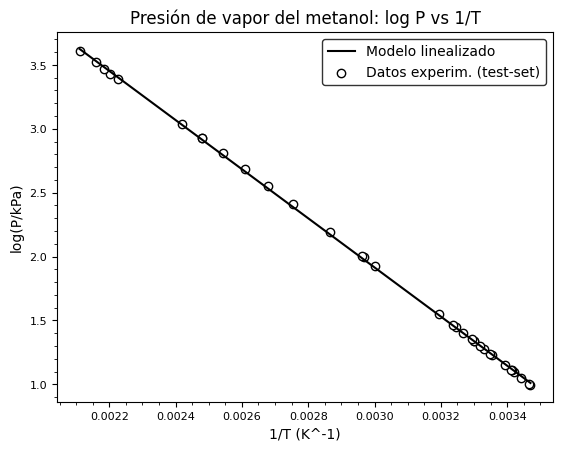

In [20]:
plt.title("Presión de vapor del metanol: log P vs 1/T")
plt.plot(x_test, y_pred, label="Modelo linealizado", color="black")
plt.scatter(
    x=x_test,
    y=y_test,
    label="Datos experim. (test-set)",
    edgecolor="black",
    facecolor="white",
)
plt.xlabel("1/T (K^-1)")
plt.ylabel("log(P/kPa)")
plt.legend(edgecolor="black")
plt.minorticks_on()
plt.show()

¡Excelente! Comprobamos gráficamente que la predicción del modelo para las *variables transformadas* (log P vs 1/T) funciona muy bien en el test-set. Ahora, la pregunta clave es: ¿cómo se desempeña el modelo para las *variables originales* (P vs T)? Recordemos que el objetivo final es tener una buena predicción de la presión de vapor (no su logaritmo).

A continuación, definimos una función para calcular la presión de saturación según el modelo de Clausius-Clapeyron y creamos una nueva columna en el DataFrame para almacenar sus resultados.

**Nota**: como las variables transformadas (log P, 1/T) y los estratos (rango_T) ya cumplieron su propósito, podemos descartarlas del DataFrame de trabajo usando el método `.drop()`.

In [21]:
def calc_Psat_Clapeyron(T, A, B):
    log_P_sat = A - B/T
    return 10 ** log_P_sat

df_final = df_trabajo.drop(columns=["log(P/kPa)", "1/T (K^-1)", "rango_T"])
df_final["P_Clapeyron (kPa)"] = calc_Psat_Clapeyron(df_final["T (K)"], A0, B0)
# primeras 5 filas
df_final.head().round(3)

,Fuente,T (K),P (kPa),P_Clapeyron (kPa)
39,Safarov (2019),274.15,4.301,4.674
40,Safarov (2019),278.15,5.508,5.895
41,Safarov (2019),283.15,7.419,7.808
0,Dever et al. (1955),287.03,9.322,9.645
1,Dever et al. (1955),287.75,9.707,10.025


Graficamos ahora todos los datos experimentales y el modelo de Clausius-Clapeyron, en un diagrama P vs T con escala lineal para ambos ejes:

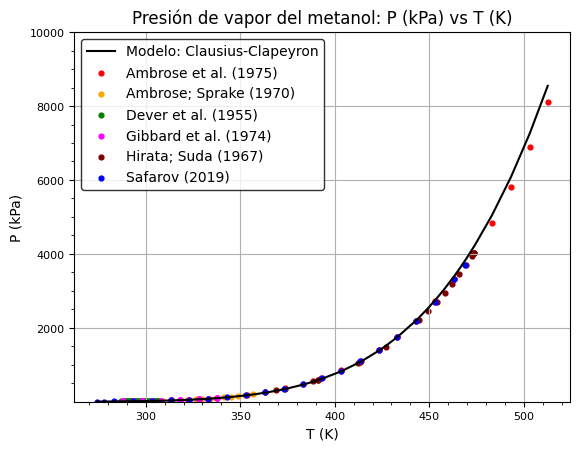

In [22]:
df_final.plot(
    x="T (K)",
    y="P_Clapeyron (kPa)",
    kind="line",
    color="black",
    label="Modelo: Clausius-Clapeyron",
)
graficar_datos_presion_vapor("T (K)", "P (kPa)")
plt.legend(edgecolor="black")
plt.ylim(1, 10_000)
#plt.yscale("log")
plt.show()

El diagrama **P vs T** muestra que el modelo tiene un mayor error absoluto alrededor de 500 K. Esta situación no estaba reflejada en el diagrama **log P vs 1/T**. Esto es un buen ejemplo de por qué es importante retornar de las variables transformadas a las originales, así como de la importancia de graficar en diferentes escalas.

Desafortunadamente, el diagrama P vs T no permite visualizar con suficiente detalle qué ocurre a bajas temperaturas (~300 K), ya que las presiones son muy bajas. Se necesita otro enfoque para analizar mejor qué ocurre en esa región.

¿El **error absoluto** es la mejor métrica de exactitud? Por ejemplo: si el modelo comete un error de 100 kPa, ¿es aceptable o no? La respuesta correcta es que *depende* del valor real. Si la presión real es 8000 kPa, un error de 100 kPa no es tan significativo. En cambio, si la presión real es 5 kPa, un error de 100 kPa sería inaceptable: la predicción rondaría entre 105 kPa (muy alta) y -95 kPa (la presión NO puede ser negativa). La solución pasa por utilizar otra métrica: porcentaje de **error relativo**. El error relativo compara el error absoluto respecto al valor real de la variable.

A continuación, definimos una función para calcular el error relativo y la evaluamos para el modelo de Clausius-Clapeyron en todos los puntos:

In [23]:
def calc_Er(valor_calc, valor_exp):
    Er = 100 * abs((valor_calc - valor_exp) / valor_exp)
    return Er

df_final["Er_Clapeyron (%)"] = calc_Er(
    df_final["P_Clapeyron (kPa)"], df_final["P (kPa)"])
# display(df_final.round(3))
display(df_final["Er_Clapeyron (%)"].describe().round(3))

count    167.000
mean       2.396
std        1.534
min        0.003
25%        1.115
50%        2.281
75%        3.585
max        8.664
Name: Er_Clapeyron (%), dtype: float64

El error relativo del modelo va desde 0.003 % hasta 8.7 %, siendo el error promedio 2.4 %. Además, hay un 75% de probabilidad de que el error para una predicción sea menor al 3.6 %. Estas métricas resumen muy bien la exactitud del modelo, pero no informan en cuáles temperaturas tenemos mayor error ni cuáles son las casos más exactos. Para obtener esta información, podemos representar un gráfico de dispersión para la distribución del error relativo del modelo en función de la temperatura:

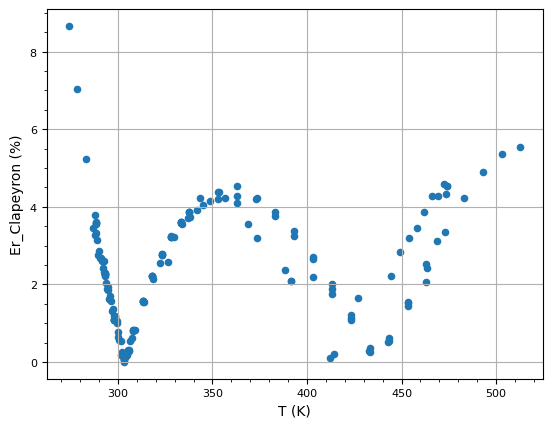

In [24]:
df_final.plot(x="T (K)", y="Er_Clapeyron (%)", kind="scatter")
plt.grid(True)
plt.minorticks_on()

El gráfico de dispersión nos confirma que el error aumenta cerca de 500 K, tal como habíamos observado en el diagrama **P vs T**. Adicionalmente, nos muestra que para T < 300 K el error también se dispara; de hecho, alcanza su máximo valor en esta región. Esto no resultaba visible en el diagrama **P vs T**.

El modelo ajustado es muy bueno, pero todavía hay oportunidad de mejora. ¿Qué alternativas hay? Una posibilidad sería dividir el problema en intervalos de temperatura más cortos. Por ejemplo: hacer un ajuste para T < 400 K y otro para T > 400 K, obteniendo para cada región diferentes parámetros (A, B). Otra alternativa es cambiar a un modelo con más parámetros ajustables. Este es el enfoque que usaremos.



## Modelo no lineal de 3 parámetros: Antoine

La ecuación de Antoine es un modelo empírico muy utilizado para modelar la presión de vapor de sustancias puras. Puede verse como una extensión de Clausius-Clapeyron con un 3er parámetro ajustable:

$$ \log(P^{sat}) = A - \frac{B}{T+C} $$

Aunque parece una modificación sencilla de Clausius-Clapeyron, introduce un cambio importante. El modelo de Antoine no  es linealizable: no existe ningún cambio de variables que transforme la ec. de Antoine en una ec. de la recta.

Para resolver este problema de regresión no lineal, utilizamos la función `curve_fit` de la librería `SciPy`. Este librería es muy para para cálculos científicos y de ingeniería que requieran métodos numéricos; además, es compatible con `NumPy` (igual que `pandas`).

Para entrenar este nuevo modelo, se deben utilizar solamente los datos del *train-set*, tal como se hizo con el modelo linealizado. En esta ocasión, conviene que las variables sean x=T; y=log P. Cabe mencionar que `curve_fit` ofrece la opción de pasar valores iniciales de los parámetros. Esto es útil para acelerar (o asegurar) la convergencia con modelos "difíciles". De hecho, si intenta ajustar este modelo sin inicializar parámetros, surgirá un error indicando que se agotó el máximo de iteraciones del método. Como inicialización, se sugiere utilizar los A y B conocidos de Clausius-Clapeyron, fijando C=0 (esta elección se deduce fácilmente de las ecuaciones).



In [25]:
from scipy.optimize import curve_fit

def calc_log_Psat_Antoine(T, A, B, C):
    return A - B/(T+C)

T_train = strat_train_set['T (K)']
log_P_train = strat_train_set['log(P/kPa)']
params_inic = [A0, B0, 0]
params, covariance = curve_fit(
    f=calc_log_Psat_Antoine,
    xdata=T_train,
    ydata=log_P_train,
    p0=params_inic
)
A1, B1, C1 = params

print(f"{A1 = :.6f}")
print(f"{B1 = :.2f}")
print(f"{C1 = :.4f}")

A1 = 7.189539
B1 = 1576.23
C1 = -33.6780


Una vez ajustado el nuevo modelo, se procede a calcular la presión y el error relativo para la población total:

In [26]:
df_final["P_Antoine (kPa)"] = 10 ** calc_log_Psat_Antoine(
    df_final["T (K)"], A1, B1, C1)
df_final["Er_Antoine (%)"] = calc_Er(
    df_final["P_Antoine (kPa)"], df_final["P (kPa)"])
# display(df_final.round(3))
display(df_final[["Er_Clapeyron (%)", "Er_Antoine (%)"]].describe().round(3))

,Er_Clapeyron (%),Er_Antoine (%)
count,167.000,167.000
mean,2.396,0.317
std,1.534,0.396
min,0.003,0.004
25%,1.115,0.078
50%,2.281,0.198
75%,3.585,0.329
max,8.664,2.230


El modelo de 3 parámetros (Antoine) es claramente superior respecto al de 2 parámetros (Clausius - Clapeyron). El error máximo disminuyó de 8.7 % a 2.2 %, mientras que el error promedio bajó 1 orden de magnitud de 2.4 % a 0.3 %. Para confirmar, graficamos en una misma figura la distribución de error de ambos modelos:

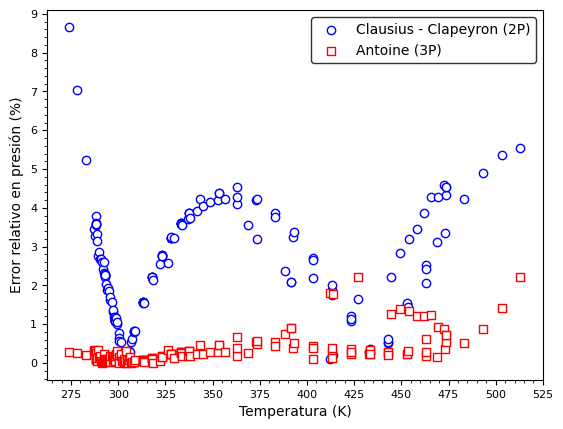

In [27]:
T_data = df_final["T (K)"]
Er_Clapeyron = df_final["Er_Clapeyron (%)"]
Er_Antoine = df_final["Er_Antoine (%)"]

plt.scatter(x=T_data, y=Er_Clapeyron, label="Clausius - Clapeyron (2P)",
            marker="o", edgecolor="blue", facecolor="white")
plt.scatter(x=T_data, y=Er_Antoine, label="Antoine (3P)",
            marker="s", edgecolor="red", facecolor="white")
plt.xlabel("Temperatura (K)")
plt.ylabel("Error relativo en presión (%)")
plt.xticks(range(275, 550, 25))
plt.yticks(range(10))
#plt.grid(True)
plt.minorticks_on()
plt.legend(edgecolor="black")
plt.show()

El gráfico de distribución de error confirma que, para la gran mayoría de las temperaturas, el modelo de Antoine (3 parámetros) es más exacto que el de Clausius-Clapyeron (2 parámetros).

Finalmente, graficamos en un diagrama P vs T (escala semi-log) el modelo de Antoine comparado con los datos experimentales:

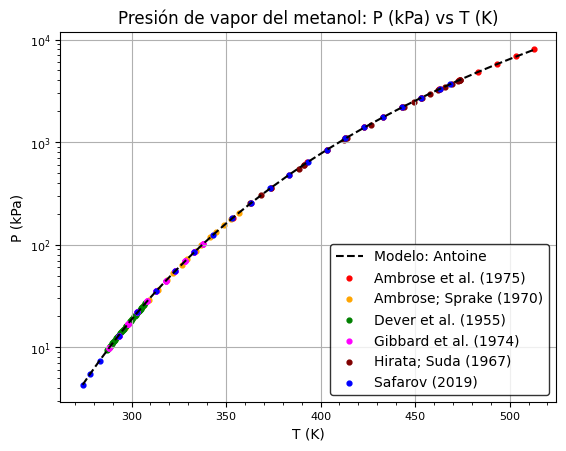

In [28]:
df_final.plot(
    x="T (K)",
    y="P_Antoine (kPa)",
    kind="line",
    color="black",
    label="Modelo: Antoine",
    linestyle="--",
)
graficar_datos_presion_vapor("T (K)", "P (kPa)")
plt.legend(edgecolor="black")
plt.yscale("log")
plt.show()

## Conclusiones

1. Los datos deben tener unidades consistentes antes de ser procesados numéricamente.

2. La librería `pint` simplifica y automatiza las conversiones de unidades.

3. La librería `pandas` es muy útil para el Análisis de Datos, ofreciendo funcionalidades desde la estructuración de los datos y cálculos de nuevos atributos hasta estadísticas descriptivas y visualización.

4. La estratificación de los datos y su apropiado reparto entre los conjuntos de entrenamiento (*train-set*) y prueba (*test-set*) son procedimientos necesarios antes de entrenar cualquier modelo.

5. Algunos modelos no lineales pueden transformarse en modelos lineales, con un apropiado cambio de variables.

6. La librería `SciKit Learn` permite entrenar varios modelos predeterminados, desde regresión lineal hasta Machine-Learning.

7. La librería `SciPy` permite definir y ajustar nuestros propios modelos no lineales de regresión.

8. Con el modelo linealizado de Clausius-Clapeyron, se logró un buen ajuste de la presión de vapor del metanol en función de la temperatura.

9. El modelo de Antoine mejoró aún más el grado de ajuste, debido a su parámetro adicional.

10. Para evaluar el desempeño de un modelo, siempre conviene analizar diferentes métricas y graficar las variables de interés en distintas proyecciones.
